# 1. Bisection


One of the most common algorithms for numerical root-finding is *bisection*.

To understand the idea, recall the well-known game where:

- Player A thinks of a secret number between 1 and 100  
- Player B asks if it’s less than 50  
  
  - If yes, B asks if it’s less than 25  
  - If no, B asks if it’s less than 75  
  

And so on.

This is bisection, a relative of [binary search](https://en.wikipedia.org/wiki/Binary_search_algorithm). It works for all sufficiently well behaved increasing continuous functions with $ f(a) < 0 < f(b) $. 

Write an implementation of the bisection algorith, `bisect(f, lower, upper, tol)` which, given a function `f`, a lower bound `lower` and an upper bound `upper` finds the point `x` where `f(x) = 0`. The parameter `tol` is a numerical tolerance, you should stop once your step size is smaller than `tol`.


Use it to minimize the function:

$$
f(x) = \sin(4 (x - 1/4)) + x + x^{20} - 1 \tag{2}
$$

in python: `lambda x: np.sin(4 * (x - 1/4)) + x + x**20 - 1`

The value where f(x) = 0 should be around `0.408`

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import statsmodels.api as sm
mpl.style.use('seaborn')

Root: 0.408


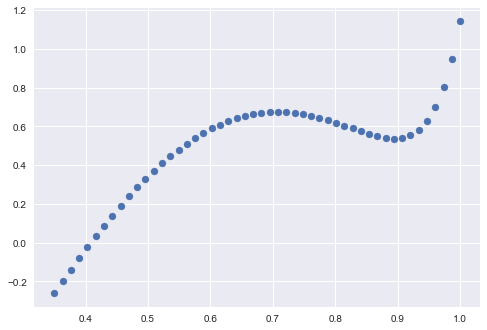

In [5]:
def bisect(f, lower, upper, tol):
    '''
    Function which uses the bisection method to find roots of continuous functions for which one knows two values with opposite
    signs.
    
    Input: 
    f : Function on which to find the root
    lower : Lower bound of the interval in which to find the root (real number)
    upper : Upper bound of the interval in which to find the root (real number)
    tol : Threshold at which the program returns the root given that the value is within the set tolerance
    
    Output:
    root = Value at which the function is within the tolerance set around 0. 
    
    '''
    low = lower
    up = upper
    f_left = f(low)
    f_right = f(up)
    sln = 'Root: '
    
    #Check if at the return value from the function at the bound ifs of opposite sign and ifone of them is within tolerance
    
    if abs(f_left) <= tol:
        root = low
        sln += f'{root:.3f}'
        return (sln)

    elif abs(f_right) <= tol:
        root = up
        sln += f'{root:.3f}'
        return (sln)
    
    elif f_left * f_right > 0:
        return 'Please provide lower and upper values for which their return values must be of opposite sign.'
    
    else:
        #Calculate midpoint between bounds and check if the return value from the function at the midpoint is within 
        #tolerance. Continue until return value is within tolerance

        mid = (low+up)/2
        mid_val = f(mid)
        if mid_val <= tol and mid_val > -tol: 
            return mid
        else:            
            while (mid_val > tol) or (mid_val < -tol):
                if mid_val > 0:
                    up = mid
                else: 
                    low = mid
                mid = (up+low)/2
                mid_val = f(mid)
                root = mid
            sln += f'{root:.3f}'
            return sln

f = lambda x : np.sin(4*(x-(1/4)))+x+(x**20)-1
lower = 0.35
upper = 1
tol = 0.001

print(bisect(f, lower, upper, tol))

#Graph
x = np.linspace(lower, upper, num=50)
plt.scatter(x, f(x))
plt.show()




# 1.2 (stretch) Recursive Bisect

Write a recursive version of the bisection algorithm

Root: 0.408


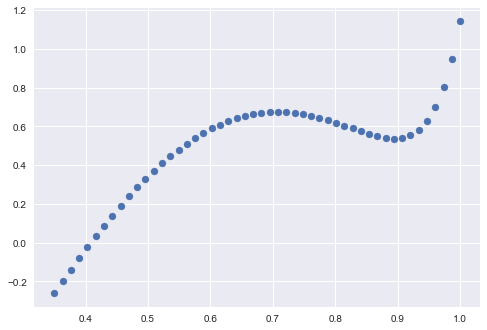

In [6]:
def bisect_recursive(f, lower, upper, tol):
    '''
    Function which uses the bisection method in a recusrive manner to find roots of continuous functions for which one knows two values with opposite
    signs.
    
    Input: 
    f : Function on which to find the root
    lower : Lower bound of the interval in which to find the root (real number)
    upper : Upper bound of the interval in which to find the root (real number)
    tol : Threshold at which the program returns the root given that the value is within the set tolerance
    
    Output:
    root = Value at which the function is within the tolerance set around 0. 
    
    '''
    low = lower
    up = upper
    f_left = f(low)
    f_right = f(up)
    sln = 'Root: '
    
    #Check if at the return value from the function at the bound ifs of opposite sign and if if one of them is within tolerance

    if abs(f_left) <= tol:
        root = low
        sln += f'{root:.3f}'
        return (sln)

    elif abs(f_right) <= tol:
        root = up
        sln += f'{root:.3f}'
        return (sln)
    
    elif f_left * f_right > 0:
        return 'Please provide lower and upper values for which their return values must be of opposite sign.'
        
    #Calculate midpoint between bounds and check if the return value from the function at the midpoint is within tolerance
    #update lower and upper bound accordingly
    else:
        mid = (low+up)/2
        if (f(mid) >=0):
            lower = low
            upper = mid
        else: 
            lower = mid
            upper = up
        return bisect_recursive(f, lower, upper, tol)    
        
    
f = lambda x : np.sin(4*(x-(1/4)))+x+(x**20)-1


lower = 0.35
upper = 1
tol = 0.001

print(bisect_recursive(f, lower, upper, tol))

#Graph
x = np.linspace(lower, upper, num=50)
plt.scatter(x, f(x))
plt.show()



# 2.1 Movies Regression

Write the best linear regression model you can on the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset?select=ratings.csv) to predict the profitability of a movie (revenue - budget). Maintain the interpretability of the model.

Few notes:

1. Clean your data! Movies where the budget or revenue are invalid should be thrown out

2. Be creative with feature engineering. You can include processing to one-hot encode the type of movie, etc.

3. The model should be useful for someone **who is thinking about making a movie**. So features like the popularity can't be used. You could, however, use the ratings to figure out if making "good" or "oscar bait" movies is a profitable strategy.

In [7]:
df_movies = pd.read_csv('data/archive/movies_metadata.csv')

C:\Users\education\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
df_mov = df_movies.copy()

#Remove movies that have not been released
df_mov = df_mov[df_mov['status'] == 'Released']

#Remove columns not needed (no data or information that appears unrelated and information available only after the release)
drop_cols = ['adult', 'imdb_id', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline','video', 'vote_average','vote_count', 'status']
df_mov = df_mov.drop(columns = drop_cols, axis = 1)

#Drop na rows with no revenue or budget
df_mov.dropna(axis = 0, how = 'any', subset = ['budget', 'revenue']).reset_index(drop= True)

#Convert budget column to integers
df_mov= df_mov[df_mov.budget.str.isnumeric()].reset_index(drop= True)
df_mov['budget'] = df_mov['budget'].astype(int)

# Convert homepage as 1 : has homepage and as 0 : does not have a web page or do not know if there is a webpage 
def has_homepage(x):
    if x!= 0: 
        return 1
    return 0

df_mov['homepage'] = df_mov['homepage'].fillna(0)
df_mov['homepage'] = df_mov['homepage'].apply(lambda x: has_homepage(x))

#Convert release date to datetime data type
df_mov['release_date'] = pd.to_datetime(df_mov['release_date'])
df_mov['release_month'] = df_mov['release_date'].dt.month
df_mov['release_year'] = df_mov['release_date'].dt.year

#Calculate revenue for each movie
df_mov['profit'] = df_mov['revenue']-df_mov['budget']

#Remove rows with titles that have less than 10000$ budget (It is assumed that the budget may be not be represented accurately
#in the data set)
df_mov = df_mov[((df_mov['budget']>200) & (df_mov['revenue']>200))].reset_index(drop = 'True')

#Convert json columns to dict
cols_json_to_dic =  ['genres', 'production_companies', 'production_countries', 'spoken_languages']

def is_empty(x):
    if len(x) == 0 :
        return ['missing']
    return x

for col in cols_json_to_dic:
    df_mov[col] = (df_mov[col].apply(eval)
                              .apply(lambda lst : [d['name'] for d in lst]))
    df_mov[col] =df_mov[col].apply(lambda x : is_empty(x))

df_mov['belongs_to_collection'] = df_mov['belongs_to_collection'].fillna(0).apply(lambda x: 1 if x != 0 else 0)


In [9]:
companies_dict = {}
for companies in df_mov['production_companies']:
    for c in companies: 
        if c in companies_dict :
            companies_dict[c] +=1
        else:
            companies_dict[c] = 0
companies_dict = dict(sorted(companies_dict.items(), key=lambda item: item[1], reverse = True))
df_companies = pd.DataFrame({'label': companies_dict.keys(),'count': companies_dict.values()})
df_companies = df_companies[df_companies['count'] >15]
companies  = list(df_companies.label)


In [10]:
def common_elements(x1, x2):
    x = set(x1)
    x2 = set(x2)
    output = x.intersection(x2)
    output = list(output)
    if len(output) == 0:
        return ['other']
    return output
        
df_mov['production_companies'] = df_mov['production_companies'].apply(lambda x : common_elements(x, companies))

In [11]:
def create_dummy_vars_from_json(data, feature):
    df = data[feature].copy()
    dummy_vars = df.str.join(sep=',').str.get_dummies(sep=',')
    dropped_col = dummy_vars.columns[0]
    dummy_vars = dummy_vars.drop(columns = dropped_col )
    return dummy_vars, dropped_col

def join_categorical_features(data, lst_cat_features, lst_num_features):
    total_lst = lst_cat_features + lst_num_features + ['profit']
    df = data[total_lst].copy()
    
    if len(lst_cat_features)>0:
        f0 = lst_cat_features.pop(0)
        dropped_values = {}

        if type(df[f0].iloc[0]) == list: 
            df_output, dropped_col = create_dummy_vars_from_json(df, f0)
            dropped_values[f0] = dropped_col
        else:
            df_output = pd.get_dummies(df[f0], drop_first = True)

        for f in lst_cat_features:
            if type(df[f].iloc[0]) == list: 
                dummy_vars, dropped_col = create_dummy_vars_from_json(df, f)
                dropped_values[f] = dropped_col
            else:
                dummy_vars = pd.get_dummies(df[f], drop_first = True)
            df_output = df_output.join(dummy_vars, lsuffix = '_')
        
        if len(lst_num_features)>0:
            for f in lst_num_features:
                df_output = df_output.join(df[f])
        print(dropped_values)

    else:
        f0 = lst_num_features.pop(0)
        df_output = df[[f0]]
        for f in lst_num_features:
            df_output = df_output.join(df[f])       
        
    df_output = df_output.join(data['profit'])
    df_output = sm.add_constant(df_output)
    return df_output


lst_cat_features =[]# ['production_companies']
lst_num_features =['budget','homepage','belongs_to_collection']
data = df_mov

X = join_categorical_features(data, lst_cat_features,lst_num_features)

X = X.dropna()
y = X.profit
X = X.drop(columns = ['profit'])



In [12]:
est = sm.OLS(y,X).fit(cov_type = 'HC2')
est.summary()

C:\Users\education\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     171.1
Date:                Fri, 05 Feb 2021   Prob (F-statistic):           9.80e-73
Time:                        20:38:48   Log-Likelihood:            -1.0589e+05
No. Observations:                5315   AIC:                         2.118e+05
Df Residuals:                    5311   BIC:                         2.118e+05
Df Model:                           3                                         
Covariance Type:                  HC2                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -2.41e+07   2.68e+06     -8.993      0.000   -2.93e+07   -1.88e+07
budget                    1.7598      0.099     17.802      0.000       1.566       1.954
homepage               3.002e+07   2.98e+06     10.061      0.000    2.42e+07    3.59e+07
belongs_to_collection  7.831e+07   4.45e+06     17.603      0.000    6.96e+07     8.7e+07
==============================================================================
Omnibus:                     4698.986   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           418956.807
Skew:                           3.815   Prob(JB):                         0.00
Kurtosis:                      45.821   Cond. No.                     1.27e+08
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 1.27e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 2.2 Movies Manual Regression

Use your `X` and `y` matrix from 2.1 to calculate the linear regression yourself using the normal equation $(X^T X)^{-1}X^Ty$.

Verify that the coefficients are the same.

In [13]:
X1 = np.array(X)
y1 = np.array(y)
coeffs = np.linalg.inv(X1.transpose()@ X1) @ X1.transpose() @ y1
lst_labels = X.columns
manual_reg = pd.DataFrame({'coefficients': coeffs})
manual_reg = manual_reg.set_index(lst_labels)
print('manual regression results'.title())
print(manual_reg)
print('\nStatsmodels results'.title())
print(est.params)

Manual Regression Results
                       coefficients
const                 -2.409732e+07
budget                 1.759799e+00
homepage               3.002183e+07
belongs_to_collection  7.830593e+07

Statsmodels Results
const                   -2.409732e+07
budget                   1.759799e+00
homepage                 3.002183e+07
belongs_to_collection    7.830593e+07
dtype: float64


# 2.3 Movies gradient descent regression

Use your `X` and `y` matrix from 2.1 to calculate the linear regression yourself using **gradient descent**. 

Hint: use `scipy.optimize` and remember we're finding the $\beta$ that minimizes the squared loss function of linear regression: $f(\beta) = (\beta X - y)^2$. This will look like part 3 of this lecture.

Verify your coefficients are similar to the ones in 2.1 and 2.2. They won't necessarily be exactly the same, but should be roughly similar.

In [14]:
from scipy import optimize

def sum_squared_loss(betas, y, X):
    sum_square_loss = np.sum(((X @ betas) - y)**2)
    return sum_square_loss

X_2_3 = np.array(X)
y_2_3 = np.array(y)
betas_2_3 = np.zeros(len(X_2_3[0]))
res = optimize.minimize(sum_squared_loss, x0 = betas_2_3, args =(y_2_3, X_2_3), method='powell')

In [15]:
gradient_descent_reg = pd.DataFrame({'coefficients': res['x']})
gradient_descent_reg = gradient_descent_reg .set_index(lst_labels)

print('manual regression results'.title())
print(manual_reg)
print('\nStatsmodels results'.title())
print(est.params)
print('\ngradient descent regression results'.title())
print(gradient_descent_reg)


Manual Regression Results
                       coefficients
const                 -2.409732e+07
budget                 1.759799e+00
homepage               3.002183e+07
belongs_to_collection  7.830593e+07

Statsmodels Results
const                   -2.409732e+07
budget                   1.759799e+00
homepage                 3.002183e+07
belongs_to_collection    7.830593e+07
dtype: float64

Gradient Descent Regression Results
                       coefficients
const                 -2.415120e+07
budget                 1.758467e+00
homepage               3.019974e+07
belongs_to_collection  7.802369e+07
